# Running TCAV

This notebook walks you through an example application of the TCAV library step-by-step to understand which human interpretable concepts (e.g. stripes, dots, zigzags) are important to the image classifier GoogleNet's (a.k.a. Inception v1) prediction of Zebras.

## Install required packages

To run through this notebook in the interim, you are encouraged to utilize a `virtualenv` or `conda` environment for installing and working with the required packages to avoid any dependency and compatability issues with different versions of packages.

In [1]:
%pip install tensorflow
%pip install tcav

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Download example models and images

Open a terminal and run the following commands:

```
cd tcav/tcav_examples/image_models/imagenet

python download_and_make_datasets.py --source_dir=YOUR_PATH --number_of_images_per_folder=50 --number_of_random_folders=3
```

This script will download the following content into separate folders into a directory you specify with the `--source_dir=` argument:

**Images**
*  ImageNet images for the target Zebra class
*  [Broden dataset](http://netdissect.csail.mit.edu/) images for three concepts (e.g. striped, dotted, zigzagged)
*  Random ImageNet class images used by TCAV for hypothesis testing of important concepts

**Models**
*  [Inception 5h model](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/inception5h.py)
*  [Mobilenet V2 model](https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md)

## Import extensions and libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

/home/ryansullivan/anaconda3/envs/tcav/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryansullivan/anaconda3/envs/tcav/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryansullivan/anaconda3/envs/tcav/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryansullivan/anaconda3/envs/

## TCAV step-by-step

You will walk through the following steps below:

1. **Store example images in each folder** (you have this if you ran the above)
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **Write a model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **Retrieve model activations** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model
4. Run TCAV and visualize scores for important concepts.

## Step 1: Store concept and target class images to local folders

... and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 

You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [4]:
print ('REMEMBER TO UPDATE YOUR_PATH (where images, models are)!')

# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'  
user = 'ryansullivan'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = "/tmp/" + user + '/' + project_name
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
cav_dir = None
# where the images live.

# TODO: replace 'YOUR_PATH' with path to downloaded models and images. 
source_dir = '/home/ryansullivan/Documents/TCAV-RL/tcav/saves/'
#source_dir = '/home/ryansullivan/Documents/TCAV-RL/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_PATH'
bottlenecks = ['fc1', 'pi']  # @param 
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
#utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'NOOP'  
concepts = ["behind_left_bunker", "behind_center_bunker", "behind_right_bunker"]  
#target = 'zebra'  
#concepts = ["striped", "dotted", "zigzagged"]  

REMEMBER TO UPDATE YOUR_PATH (where images, models are)!


## Step 2: Write your model wrapper

The next step is to tell TCAV how to communicate with your model. See `model.GoogleNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 2.1: Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2.2: Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 2.3: Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 2.4: Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! See the two example model wrapers, InceptionV3 and Googlenet in `tcav/model.py`.

In [5]:
# Create TensorFlow session.
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
#GRAPH_PATH = source_dir + "/inception5h/tensorflow_inception_graph.pb"
GRAPH_PATH = "/home/ryansullivan/Documents/TCAV-RL/tcav/saves/squared_flip_agent_42.pb"

# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...ls

#LABEL_PATH = source_dir + "/inception5h/imagenet_comp_graph_label_strings.txt"
LABEL_PATH = "/home/ryansullivan/Documents/TCAV-RL/tcav/saves/a2c_comp_graph_label_strings.txt"

#mymodel = model.GoogleNetWrapper_public(sess, GRAPH_PATH, LABEL_PATH)
mymodel = model.A2C2Wrapper_public(sess, GRAPH_PATH, LABEL_PATH)

#print(mymodel)
#print([n.name for n in tf.compat.v1.get_default_graph().as_graph_def().node])

model/c1/w
model/c1/w/read
model/c1/b
model/c1/b/read
model/c2/w
model/c2/w/read
model/c2/b
model/c2/b/read
model/c3/w
model/c3/w/read
model/c3/b
model/c3/b/read
model/fc1/w
model/fc1/w/read
model/fc1/b
model/fc1/b/read
model/vf/w
model/vf/w/read
model/vf/b
model/vf/b/read
model/pi/w
model/pi/w/read
model/pi/b
model/pi/b/read
train_model/input/Ob
train_model/input/Cast
train_model/input/sub/y
train_model/input/sub
train_model/input/truediv/y
train_model/input/truediv
train_model/model/c1/Reshape/shape
train_model/model/c1/Reshape
train_model/model/c1/Conv2D
train_model/model/c1/add
train_model/model/Relu
train_model/model/c2/Reshape/shape
train_model/model/c2/Reshape
train_model/model/c2/Conv2D
train_model/model/c2/add
train_model/model/Relu_1
train_model/model/c3/Reshape/shape
train_model/model/c3/Reshape
train_model/model/c3/Conv2D
train_model/model/c3/add
train_model/model/Relu_2
train_model/model/Reshape/shape
train_model/model/Reshape
train_model/model/fc1/MatMul
train_model/model

## Step 3: Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [6]:
act_generator = act_gen.A2CActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## Step 4: Run TCAV and visualize concept importance

You are now ready to run TCAV! Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores.


In [7]:
import absl
absl.logging.set_verbosity(3)
num_random_exp=50
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   "LEFTFIRE",
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:TCAV will 5200 params
This may take a while... Go get coffee!
INFO:tensorflow:Running param 0 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_0']
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 does not exist, Making one...
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 does not exist, Making one...
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 does not exist, Making one...
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.8181818181818182, 'random500_0': 0.7878787878787878, 'overall': 0.803030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.8181818181818182, 'random500_0': 0.7878787878787878, 'overall': 0.803030303030303}
INFO:tensorf

INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 10 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_

INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 19 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_28': 0.12121212121212122, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_28': 0.12121212121212122, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 29 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Tr

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.6060606060606061, 'random500_37': 0.9696969696969697, 'overall': 0.7878787878787878}
INFO:tensorflow:Running param 38 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.5454545454545454, 'random500_38': 0.9696969696969697, 'overall': 0.7575757575757576}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behin

INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 48 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.8181818181818182, 'random500_6': 0.9393939393939394, 'overall': 0.8787878787878788}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.8181818181818182, 'random500_6': 0.9393939393939394, 'overall': 0.8787878787878788}
INFO:tensorflow:Running param 57 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (1

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_15': 0.45454545454545453, 'overall': 0.7272727272727273}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_15': 0.45454545454545453, 'overall': 0.7272727272727273}
INFO:tensorflow:Running param 66 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_16': 0.

INFO:tensorflow:Running param 75 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.7878787878787878, 'random500_25': 0.8787878787878788, 'overall': 0.8333333333333334}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.7878787878787878, 'random500_25': 0.8787878787878788, 'overall': 0.8333333333333334}
INFO:tensorflow:Running param 76 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.8181818181818182, 'random500_34': 0.9696969696969697, 'overall': 0.8939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.8181818181818182, 'random500_34': 0.9696969696969697, 'overall': 0.8939393939393939}
INFO:tensorflow:Running param 85 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.8125, 'random500_43': 0.9090909090909091, 'overall': 0.8615384615384616}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.8125, 'random500_43': 0.9090909090909091, 'overall': 0.8615384615384616}
INFO:tensorflow:Running param 94 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:acc per class {'behind_right_bunker': 1.0, 'random500_2': 0.45454545454545453, 'overall': 0.7272727272727273}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_2': 0.45454545454545453, 'overall': 0.7272727272727273}
INFO:tensorflow:Running param 103 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.9696969696969697, 'random500_3': 0.6666666666666666, 'overall': 0.81818

INFO:tensorflow:Running param 112 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 1.0, 'random500_12': 0.6060606060606061, 'overall': 0.803030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_12': 0.6060606060606061, 'overall': 0.803030303030303}
INFO:tensorflow:Running param 113 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_13']
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.8181818181818182, 'random500_21': 0.9090909090909091, 'overall': 0.8636363636363636}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.8181818181818182, 'random500_21': 0.9090909090909091, 'overall': 0.8636363636363636}
INFO:tensorflow:Running param 122 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 sha

INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.8484848484848485, 'random500_30': 0.8787878787878788, 'overall': 0.8636363636363636}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.8484848484848485, 'random500_30': 0.8787878787878788, 'overall': 0.8636363636363636}
INFO:tensorflow:Running param 131 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_31'] - fc1 alpha 0.1
INFO:tens

INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.36363636363636365, 'random500_40': 1.0, 'overall': 0.6818181818181818}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.36363636363636365, 'random500_40': 1.0, 'overall': 0.6818181818181818}
INFO:tensorflow:Running param 141 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 1.0, 'random500_49': 0.7878787878787878, 'overall': 0.8939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_49': 0.7878787878787878, 'overall': 0.8939393939393939}
INFO:tensorflow:Running param 150 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per cl

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 160 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 161 of 5200
INFO:tensorflow:running LEFTFIRE ['ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 171 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INF

INFO:tensorflow:Running param 181 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 182 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_42': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_42': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 192 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorfl

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 202 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1':

INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 213 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 223 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INF

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.3939393939393939, 'random500_34': 0.5454545454545454, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 233 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.12121212121212122, 'random500_35': 0.7878787878787878, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.12121212121212122, 'random5

INFO:tensorflow:Running param 243 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_45': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_45': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 244 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_tes

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 254 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow

INFO:tensorflow:Training CAV ['random500_2', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.45454545454545453, 'random500_16': 0.6060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.45454545454545453, 'random500_16': 0.6060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 264 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_17'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow

INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 274 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 275 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_28']
INFO:tensorflow:Loaded /tmp

INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 285 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 295 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorf

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 305 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3':

INFO:tensorflow:Running param 315 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 316 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.6363636363636364, 'random500_29': 0.30303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.6363636363636364, 'random500_29': 0.30303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 326 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV

INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 336 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_40': 0.0, 'overal

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 347 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Tr

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 357 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 358 of 5200
INFO:tensorflow:running LEFTFIRE ['ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 368 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INF

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 378 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 379 of 5200
INFO:tensorflow:running LEFTFIRE ['ra

INFO:tensorflow:Running param 388 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 389 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 399 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Tr

INFO:tensorflow:Training CAV ['random500_5', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.5454545454545454, 'random500_14': 0.45454545454545453, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.5454545454545454, 'random500_14': 0.45454545454545453, 'overall': 0.5}
INFO:tensorflow:Running param 409 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5':

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 419 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.5151515151515151, 'random500_25': 0.30303030303030304, 'overall': 0.4090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.5151515151515151, 'random500_25': 0.30303030303030304, 'overall': 0.40909

INFO:tensorflow:CAV accuracies: {'random500_5': 0.8787878787878788, 'random500_34': 0.2727272727272727, 'overall': 0.5757575757575758}
INFO:tensorflow:Running param 429 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 430 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5'

INFO:tensorflow:Running param 439 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 440 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 450 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Tr

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_16': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 460 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_17'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 461 of 5200
INFO:t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 471 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 481 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.9393939393939394, 'random500_38': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tenso

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 491 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 492 of 5200
INFO:tensorflow:running LEFTFIRE ['ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 502 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 512 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.2727272727272727, 'random500_20': 0.5757575757575758, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anyt

INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.48484848484848486, 'random500_30': 0.42424242424242425, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.48484848484848486, 'random500_30': 0.42424242424242425, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 523 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activa

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 533 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorf

INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 543 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_1': 0.0, 'overall': 0.5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.3939393939393939, 'random500_12': 0.8181818181818182, 'overall': 0.6060606060606061}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.3939393939393939, 'random500_12': 0.8181818181818182, 'overall': 0.6060606060606061}
INFO:tensorflow:Running param 554 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV [

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.3939393939393939, 'random500_22': 0.6666666666666666, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 564 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 565 

INFO:tensorflow:Running param 574 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 575 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_43': 0.09090909090909091, 'overall': 0.5384615384615384}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_43': 0.09090909090909091, 'overall': 0.5384615384615384}
INFO:tensorflow:Running param 585 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_44

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 595 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9':

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 606 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_25': 0.18181818181818182, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_25': 0.18181818181818182, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 616 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training C

INFO:tensorflow:Training CAV ['random500_9', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.5151515151515151, 'random500_35': 0.5454545454545454, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.5151515151515151, 'random500_35': 0.5454545454545454, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 626 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:a

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_45': 0.42424242424242425, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 636 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.9393939393939394, 'random500_46': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.9393939393939394, 'random500_46': 0.0, 'ove

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 647 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorfl

INFO:tensorflow:Training CAV ['random500_10', 'random500_17'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 657 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_18': 0.09090909090909091, 'overall': 0

INFO:tensorflow:Running param 667 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 668 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 678 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 688 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.7878787878787878, 'random500_8': 0.06060606060606061, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 698 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 69

INFO:tensorflow:Running param 708 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 709 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 719 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.030303030303030304, 'random500_40': 0.9090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.030303030303030304, 'random500_40': 0.9090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 729 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:L

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.9090909090909091, 'random500_0': 0.12121212121212122, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.9090909090909091, 'random500_0': 0.12121212121212122, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 739 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 750 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INF

INFO:tensorflow:Training CAV ['random500_12', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.18181818181818182, 'random500_22': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.18181818181818182, 'random500_22': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 760 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Training CAV ['random500_12', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 770 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorf

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.06060606060606061, 'random500_42': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.06060606060606061, 'random500_42': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 780 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_43': 0.0, 'overall': 0.50

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 790 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INF

INFO:tensorflow:Running param 800 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 801 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.8181818181818182, 'random500_24': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.8181818181818182, 'random500_24': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 811 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Trainin

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 821 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 822 of 5200
INFO:tensorflow:running LEFTFIR

INFO:tensorflow:Running param 831 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 832 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 842 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 852 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.030303030303030304, 'random500_26': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.030303030303030304, 'random500_26': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 862 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'rand

INFO:tensorflow:Training CAV ['random500_14', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.030303030303030304, 'random500_36': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.030303030303030304, 'random500_36': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:Running param 872 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'rando

INFO:tensorflow:Training CAV ['random500_14', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.36363636363636365, 'random500_46': 0.696969696969697, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.36363636363636365, 'random500_46': 0.696969696969697, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 882 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensor

INFO:tensorflow:acc per class {'random500_15': 0.12121212121212122, 'random500_6': 0.7272727272727273, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.12121212121212122, 'random500_6': 0.7272727272727273, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 892 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not sav

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 903 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 913 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.06060606060606061, 'random500_38': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.06060606060606061, 'random500_38': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:Running param 923 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.48484848484848486, 'random500_48': 0.3333333333333333, 'overall': 0.4090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.48484848484848486, 'random500_48': 0.3333333333333333, 'overall': 0.4090909090909091}
INFO:tensorflow:Running param 933 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.2727272727272727, 'random500_49': 0.87

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 943 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.2727272727272727, 'random500_9': 0.6666666666666666, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.2727272727272727, 'random500_9': 0.6666666666666666, 'overall': 0.4696969

INFO:tensorflow:Running param 953 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.18181818181818182, 'random500_20': 0.9393939393939394, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.18181818181818182, 'random500_20': 0.9393939393939394, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 954 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_21']
INFO:tensorflow:Loa

INFO:tensorflow:Running param 963 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 964 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 974 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.030303030303030304, 'random500_0': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.030303030303030304, 'random500_0': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 984 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500

INFO:tensorflow:Training CAV ['random500_17', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 994 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorf

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1004 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1005 of 5200
INFO:tensorflow:running LEFTF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1015 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
IN

INFO:tensorflow:Training CAV ['random500_17', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.24242424242424243, 'random500_42': 0.7878787878787878, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.24242424242424243, 'random500_42': 0.7878787878787878, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1025 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tens

INFO:tensorflow:acc per class {'random500_18': 0.48484848484848486, 'random500_2': 0.6363636363636364, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.48484848484848486, 'random500_2': 0.6363636363636364, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 1035 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not savi

INFO:tensorflow:Running param 1045 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1046 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1056 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.9090909090909091, 'random500_34': 0.09090909090909091, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.9090909090909091, 'random500_34': 0.09090909090909091, 'overall': 0.5}
INFO:tensorflow:Running param 1066 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.36363636363636365, 'random500_35': 0.6666666666666666, 'overall': 0

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1076 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.12121212121212122, 'random500_45': 0.8181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.12121212121212122, 'random500_45': 0.8181818181818182, 'overall': 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1086 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.24242424242424243, 'random500_5': 0.42424242424242425, 'overall': 0.3333333333333333}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.24242424242424243, 'random500_5': 0.42424242424242425, 'overall': 0.33

INFO:tensorflow:Running param 1096 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1097 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_26': 0.9090909090909091, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_26': 0.9090909090909091, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 1107 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cl

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.030303030303030304, 'random500_36': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.030303030303030304, 'random500_36': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1117 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'ran

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1127 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.30303030303030304, 'random500_47': 0.7878787878787878, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.30303030303030304, 'random500_47': 0.7878787878787878, 'overall': 

INFO:tensorflow:Running param 1137 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1138 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_17'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1148 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_20', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1158 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:Running param 1168 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.7272727272727273, 'random500_39': 0.24242424242424243, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.7272727272727273, 'random500_39': 0.24242424242424243, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1169 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_40']
INFO:tensorflow

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1178 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1179 of 5200
INFO:tensorflow:running LEFTF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1189 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1199 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.030303030303030304, 'random500_20': 0.9393939393939394, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not sa

INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1209 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1210 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_32']
INFO:tensorflow:Lo

INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1220 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tca

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1230 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorf

INFO:tensorflow:acc per class {'random500_22': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1240 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_12': 0.0,

INFO:tensorflow:CAV accuracies: {'random500_22': 0.09090909090909091, 'random500_21': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1250 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1251 of 5200
INFO:tensorflow:running LEFTFIRE ['ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1261 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 1271 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_44'] - fc1 alpha 0.1
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1281 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.9090909090909091, 'random500_4': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving an

INFO:tensorflow:Running param 1291 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.6060606060606061, 'random500_14': 0.3939393939393939, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.6060606060606061, 'random500_14': 0.3939393939393939, 'overall': 0.5}
INFO:tensorflow:Running param 1292 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1302 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1312 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1322 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:CAV accuracies: {'random500_24': 0.9696969696969697, 'random500_5': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1332 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1333 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random50

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1343 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1353 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1363 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_38': 1.0,

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.6666666666666666, 'random500_48': 0.30303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.6666666666666666, 'random500_48': 0.30303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1374 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1384 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
IN

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1394 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.7575757575757576, 'random500_30': 0.18181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.7575757575757576, 'random500_30': 0.18181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 1405 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/act

INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1415 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tca

INFO:tensorflow:Training CAV ['random500_26', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1425 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:sa

INFO:tensorflow:Running param 1435 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1436 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1446 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_32': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_32': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1456 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_42': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_42': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1466 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.030303030303030304, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. N

INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1477 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_clas

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1487 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:Training CAV ['random500_27', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1497 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1507 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1508 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_36']
INFO:tensorflow:Lo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1518 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1528 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
IN

INFO:tensorflow:Running param 1538 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1539 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1549 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1559 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1569 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.24242424242424243, 'random500_48': 0.7575757575757576, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.24242424242424243, 'random500_48': 0.7575757575757576, 'overall': 0.5}
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.3939393939393939, 'random500_8': 0.45454545454545453, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.3939393939393939, 'random500_8': 0.45454545454545453, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 1580 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded

INFO:tensorflow:Training CAV ['random500_29', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1590 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:Running param 1600 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1601 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
I

INFO:tensorflow:Training CAV ['random500_29', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1611 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_41': 0.030303030303030304, 'overall':

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1621 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.09090909090909091, 'random500_1': 0.9090909090909091, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.09090909090909091, 'random500_1': 0.9090909090909091, 'overall': 0.5}
INFO:tensorflow:

INFO:tensorflow:Running param 1631 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1632 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.8181818181818182, 'random500_21': 0.21212121212121213, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.8181818181818182, 'random500_21': 0.21212121212121213, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1642 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Traini

INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1652 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_33': 0.0,

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 1663 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTF

INFO:tensorflow:Training CAV ['random500_31', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.8181818181818182, 'random500_3': 0.30303030303030304, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.8181818181818182, 'random500_3': 0.30303030303030304, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 1673 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1683 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1693 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1694 of 5200
INFO:tensorflow:running LEFTF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1704 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.06060606060606061, 'random500_45': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.06060606060606061, 'random500_45': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:Running param 1714 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.7878787878787878, 'random500_5': 0.2727272727272727, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.7878787878787878, 'random500_5': 0.2727272727272727, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1724 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.06060606060606061, 'random500_6': 1.0, 'over

INFO:tensorflow:CAV accuracies: {'random500_32': 0.9696969696969697, 'random500_15': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1734 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.9090909090909091, 'random500_16': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.9090909090909091, 'random500_16': 0.030303030303030304, 'overall': 0.4696969696969697}
IN

INFO:tensorflow:CAV accuracies: {'random500_32': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1744 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.6363636363636364, 'random500_26': 0.42424242424242425, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.6363636363636364, 'random500_26': 0.42424242424242425, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1745 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.09090909090909091, 'random500_37': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.09090909090909091, 'random500_37': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1755 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.12121212121212122, 'random500_47': 0.8787878787878788, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.12121212121212122, 'random500_47': 0.8787878787878788, 'overall': 0.5}
INFO:tensorflow:Running param 1765 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'rando

INFO:tensorflow:CAV accuracies: {'random500_33': 0.030303030303030304, 'random500_7': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:Running param 1775 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1776 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1786 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.8181818181818182, 'random500_28': 0.18181818181818182, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.8181818181818182, 'random500_28': 0.18181818181818182, 'overall': 0.5}
INFO:tensorflow:Running param 1796 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'rando

INFO:tensorflow:acc per class {'random500_33': 0.9696969696969697, 'random500_39': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.9696969696969697, 'random500_39': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:Running param 1806 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1816 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.24242424242424243, 'random500_0': 0.7878787878787878, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.24242424242424243, 'random500_0': 0.7878787878787878, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1817 of 52

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1827 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1837 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1848 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tca

INFO:tensorflow:Training CAV ['random500_34', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.15151515151515152, 'random500_42': 0.7272727272727273, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.15151515151515152, 'random500_42': 0.7272727272727273, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 1858 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tens

INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1868 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1869 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_4']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Running param 1878 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1879 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1889 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1899 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.30303030303030304, 'random500_34': 0.8181818181818182, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not savi

INFO:tensorflow:Running param 1909 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1910 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1920 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
IN

INFO:tensorflow:Running param 1930 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.030303030303030304, 'random500_16': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.030303030303030304, 'random500_16': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1931 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.06060606060606061, 'random500_26': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.06060606060606061, 'random500_26': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1941 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Lo

INFO:tensorflow:Training CAV ['random500_36', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.9696969696969697, 'random500_37': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.9696969696969697, 'random500_37': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1951 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.09090909090909091, 'random500_47': 0.9393939393939394, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1961 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running pa

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1972 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:ten

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1982 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:Training CAV ['random500_37', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1992 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2002 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2003 of 5200
INFO:tensorflow:running LEFTF

INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.030303030303030304, 'random500_0': 0.8787878787878788, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.030303030303030304, 'random500_0': 0.8787878787878788, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 2013 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activ

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2023 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:Training CAV ['random500_38', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2033 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 1.0, 'random500_21': 0.06060606060606061, 'overall': 

INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2043 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2044 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_32']
INFO:tensorflow:Lo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2054 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Training CAV ['random500_39', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2064 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:sa

INFO:tensorflow:Running param 2074 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2075 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2085 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.48484848484848486, 'random500_33': 0.48484848484848486, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.48484848484848486, 'random500_33': 0.48484848484848486, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2095 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.5454545454545454, 'random500_34':

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2105 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.12121212121212122, 'random500_45': 0.7575757575757576, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.12121212121212122, 'random500_45': 0.7575757575757576, 'overall': 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2116 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:ten

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2126 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.8484848484848485, 'random500_16': 0.24242424242424243, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not savi

INFO:tensorflow:Running param 2136 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.36363636363636365, 'random500_26': 0.45454545454545453, 'overall': 0.4090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.36363636363636365, 'random500_26': 0.45454545454545453, 'overall': 0.4090909090909091}
INFO:tensorflow:Running param 2137 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_27']
INFO:tensorflow

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.09090909090909091, 'random500_36': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.09090909090909091, 'random500_36': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2147 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2157 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_41', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.9393939393939394, 'random500_7': 0.030303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.9393939393939394, 'random500_7': 0.030303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2167 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2177 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.9393939393939394, 'random500_18': 0.12121212121212122, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuraci

INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2187 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2188 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_29']
INFO:tensorflow:Lo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2198 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.9696969696969697, 'random500_49': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.9696969696969697, 'random500_49': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2208 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.6363636363636364, 'random500_0': 0.42424242424242425, 'overall': 0.530

INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2218 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2219 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_11']
INFO:tensorflow:Loa

INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.36363636363636365, 'random500_20': 0.6666666666666666, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.36363636363636365, 'random500_20': 0.6666666666666666, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2229 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/act

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2239 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:acc per class {'random500_42': 0.9090909090909091, 'random500_40': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.9090909090909091, 'random500_40': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 2249 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. 

INFO:tensorflow:CAV accuracies: {'random500_43': 0.96875, 'random500_1': 0.030303030303030304, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 2259 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.8787878787878788, 'random500_2': 0.0625, 'overall': 0.47692307692307695}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.8787878787878788, 'random500_2': 0.0625, 'overall': 0.47692307692307695}
INFO:tensorflow:Running param

INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_11': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2269 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.90625, 'random500_12': 0.030303030303030304, 'overall': 0.46153846153846156}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.90625, 'random500_12': 0.030303030303030304, 'overall': 0.46153846153846156}
INFO:tensorflow:Running param 2270 of 5

INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_21': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 2279 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.9696969696969697, 'random500_22': 0.09375, 'overall': 0.5384615384615384}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.9696969696969697, 'random500_22': 0.09375, 'overall': 0.5384615384615384}
INFO:tensorflow:Running param 2280 of 5200
I

INFO:tensorflow:Running param 2289 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_32': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_32': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2290 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random

INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.21212121212121213, 'random500_42': 0.71875, 'overall': 0.46153846153846156}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.21212121212121213, 'random500_42': 0.71875, 'overall': 0.46153846153846156}
INFO:tensorflow:Running param 2300 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2310 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorf

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2320 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2330 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.030303030303030304, 'random500_24': 0.9090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accurac

INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2340 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.36363636363636365, 'random500_34': 0.6060606060606061, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.36363636363636365, 'random500_34': 0.6060606060606061, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 234

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2351 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_45', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.09090909090909091, 'random500_5': 0.6363636363636364, 'overall': 0.36363636363636365}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.09090909090909091, 'random500_5': 0.6363636363636364, 'overall': 0.36363636363636365}
INFO:tensorflow:Running param 2361 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorf

INFO:tensorflow:Running param 2371 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2372 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_26': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_26': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2382 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_

INFO:tensorflow:Training CAV ['random500_45', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2392 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2402 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_48': 0.0,

INFO:tensorflow:Running param 2412 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2413 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2423 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:acc per class {'random500_46': 0.12121212121212122, 'random500_28': 0.7878787878787878, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.12121212121212122, 'random500_28': 0.7878787878787878, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 2433 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.030303030303030304, 'random500_38': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2443 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.6666666666666666, 'random500_39': 0.24242424242424243, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.6666666666666666, 'random500_39':

INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.9393939393939394, 'random500_0': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.9393939393939394, 'random500_0': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:Running param 2454 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2464 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_47', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2474 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:CAV accuracies: {'random500_47': 0.9090909090909091, 'random500_30': 0.09090909090909091, 'overall': 0.5}
INFO:tensorflow:Running param 2484 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.48484848484848486, 'random500_31': 0.3939393939393939, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.48484848484848486, 'random500_31': 0.3939393939393939, 'overall': 0.4393939393939394}
INFO

INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2495 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tca

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2505 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
IN

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2515 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2516 of 5200
INFO:tensorflow:running LEFTF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.2727272727272727, 'random500_23': 0.7878787878787878, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.2727272727272727, 'random500_23': 0.7878787878787878, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2526 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Load

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2536 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_48', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.25, 'random500_43': 0.8787878787878788, 'overall': 0.5692307692307692}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.25, 'random500_43': 0.8787878787878788, 'overall': 0.5692307692307692}
INFO:tensorflow:Running param 2546 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.7575757575757576, 'random500_4': 0.30303030303030304, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2556 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 25

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2567 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2577 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'

INFO:tensorflow:Running param 2587 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.48484848484848486, 'random500_36': 0.3939393939393939, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.48484848484848486, 'random500_36': 0.3939393939393939, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 2588 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_37']
INFO:tensorflow:L

INFO:tensorflow:Running param 2597 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2598 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
I

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.696969696969697, 'random500_6': 0.6060606060606061, 'overall': 0.6515151515151515}
INFO:tensorflow:Running param 2607 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_7': 0.0, 'overall': 0.5}


INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2617 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEF

INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_25': 0.8787878787878788, 'overall': 0.6818181818181818}
INFO:tensorflow:Running param 2626 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.48484848484848486, 'random500_26': 0.8787878787878788, 'overall': 0.6818181818181818}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_26': 0.8787

INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.5151515151515151, 'random500_35': 0.9696969696969697, 'overall': 0.7424242424242424}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.5151515151515151, 'random500_35': 0.9696969696969697, 'overall': 0.7424242424242424}
INFO:tensorflow:Running param 2636 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi does not exist, M

INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_44': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_44': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2645 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_left_bunker', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi does not exist, Making one...
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INF

INFO:tensorflow:Running param 2654 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2655 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_beh

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.42424242424242425, 'random500_13': 0.9393939393939394, 'overall': 0.6818181818181818}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.42424242424242425, 'random500_13': 0.9393939393939394, 'overall': 0.6818181818181818}
INFO:tensorflow:Running param 2664 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_22': 0.09090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 2673 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_23': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.5151515151515151, 'random500_32': 1.0, 'overall': 0.7575757575757576}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.5151515151515151, 'random500_32': 1.0, 'overall': 0.7575757575757576}
INFO:tensorflow:Running param 2683 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2692 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_center_bunker', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_42'] - pi alpha 0.1
IN

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.9696969696969697, 'random500_0': 0.5757575757575758, 'overall': 0.7727272727272727}
INFO:tensorflow:Running param 2701 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.06060606060606061, 'random500_1': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.060606060

INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.8787878787878788, 'random500_10': 0.6060606060606061, 'overall': 0.7424242424242424}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.8787878787878788, 'random500_10': 0.6060606060606061, 'overall': 0.7424242424242424}
INFO:tensorflow:Running param 2711 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_11']
INFO:tensorflow:Loaded /tmp/ry

INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.24242424242424243, 'random500_19': 1.0, 'overall': 0.6212121212121212}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.24242424242424243, 'random500_19': 1.0, 'overall': 0.6212121212121212}
INFO:tensorflow:Running param 2720 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.3939393939393939, 'random500_28': 0.9393939393939394, 'overall': 0.6666666666666666}
INFO:tensorflow:Running param 2729 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 1.0, 'random500_29': 0.24242424242424243, 'overall': 0.6212121212121212}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_29': 0.24242424242424243, 'overall': 0.621212

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.3939393939393939, 'random500_38': 0.9393939393939394, 'overall': 0.6666666666666666}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.3939393939393939, 'random500_38': 0.9393939393939394, 'overall': 0.6666666666666666}
INFO:tensorflow:Running param 2739 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
IN

INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_47': 0.24242424242424243, 'overall': 0.6212121212121212}
INFO:tensorflow:Running param 2748 of 5200
INFO:tensorflow:running LEFTFIRE ['behind_right_bunker', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 1.0, 'random500_48': 0.18181818181818182, 'overall': 0.5909090909090909}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 1.0, 'random500_48': 0.18181818181818182, 'overall': 0.5909090909090909}
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2759 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Training CAV ['random500_0', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.9393939393939394, 'random500_19': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.9393939393939394, 'random500_19': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 2769 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'rando

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2780 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CA

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2790 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_0', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2801 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ry

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2811 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.

INFO:tensorflow:CAV accuracies: {'random500_1': 0.45454545454545453, 'random500_22': 0.5151515151515151, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2821 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2822 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'ran

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2832 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:

INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2842 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_1', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2853 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ry

INFO:tensorflow:Training CAV ['random500_2', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2863 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2874 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2884 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2885 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2895 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:

INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2906 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/

INFO:tensorflow:Training CAV ['random500_3', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2916 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2927 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activat

INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2937 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_3', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.24242424242424243, 'random500_41': 0.8181818181818182, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2948 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['ra

INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2958 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_13': 0.0, 'overall': 0.5}


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2969 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CA

INFO:tensorflow:Running param 2979 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2980 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loade

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.8787878787878788, 'random500_44': 0.030303030303030304, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.8787878787878788, 'random500_44': 0.030303030303030304, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 2990 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_4', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['rando

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.5454545454545454, 'random500_4': 0.5454545454545454, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.5454545454545454, 'random500_4': 0.5454545454545454, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 3000 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_

INFO:tensorflow:CAV accuracies: {'random500_5': 0.7878787878787878, 'random500_15': 0.24242424242424243, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3010 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.030303030303030304, 'random500_16': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.030303030303030304, 'random500_16': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 301

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3021 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_36': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_36': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3031 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not savi

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3042 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_5', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3052 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3063 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.9696969696969697, 'random500_29': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.9696969696969697, 'random500_29': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3073 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not savi

INFO:tensorflow:Running param 3083 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_40': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_40': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3084 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_6', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activa

INFO:tensorflow:Training CAV ['random500_7', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.5151515151515151, 'random500_0': 0.5454545454545454, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.5151515151515151, 'random500_0': 0.5454545454545454, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3094 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'r

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.030303030303030304, 'random500_11': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3104 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3105 of 5200
INFO:tensorfl

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3115 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CA

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3125 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.

INFO:tensorflow:Running param 3135 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 3136 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_7', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3146 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'ra

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.030303030303030304, 'random500_15': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.030303030303030304, 'random500_15': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3157 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activat

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3167 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3168 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Training CAV ['random500_8', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3178 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:Running param 3188 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_47': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_47': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3189 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_8', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activa

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_7': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_7': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3199 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/a

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3209 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.696969696969697, 'random500_19': 0.24242424242424243, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.696969696969697, 'random500_19': 0.24242424242424243, 'overall': 0.4696969696969697

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.42424242424242425, 'random500_29': 0.48484848484848486, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.42424242424242425, 'random500_29': 0.48484848484848486, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 3220 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3230 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_9', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_40': 1.0, 'overall': 0.5}


INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3241 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activa

INFO:tensorflow:Training CAV ['random500_10', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3251 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:Running param 3261 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3262 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_10', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3272 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:Running param 3282 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 3283 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_10', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_p

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.06060606060606061, 'random500_3': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.06060606060606061, 'random500_3': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3293 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_4'] - pi alph

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3303 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3313 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3314 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_26']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:CAV accuracies: {'random500_11': 0.12121212121212122, 'random500_34': 0.9393939393939394, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3323 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3324 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3334 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_11', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.21212121212121213, 'random500_5': 0.8181818181818182, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.21212121212121213, 'random500_5': 0.8181818181818182, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3344 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.24242424242424243, 'random500_6': 0.696969696969697,

INFO:tensorflow:Running param 3354 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3355 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_12', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3365 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3375 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3376 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_39']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3386 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_12', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3396 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.6363636363636364, 'random500_9': 0.15151515151515152, 'overall': 0.3939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3407 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3417 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_31': 0.0, 'overall'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3428 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_13', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3438 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.7575757575757576, 'random500_12': 0.21212121212121213, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.7575757575757576, 'random500_12': 0.21212121212121213, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3449 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3459 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.3333333333333333, 'random500_34': 0.5454545454545454, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.3333333333333333, 'random500_34': 0.5454545454545454, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 3470 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/act

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3480 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_14', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 3490 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3491 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:Training CAV ['random500_15', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.18181818181818182, 'random500_16': 0.7575757575757576, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.18181818181818182, 'random500_16': 0.7575757575757576, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3501 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc

INFO:tensorflow:Running param 3511 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3512 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3522 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_15': 0.21212121212121213, 'random500_47': 0.7272727272727273, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3532 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3533 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_15'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3543 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3553 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3554 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3564 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Training CAV ['random500_16', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3574 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_16', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.5151515151515151, 'random500_41': 0.3939393939393939, 'overall

INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3584 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3585 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansul

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.5151515151515151, 'random500_11': 0.5757575757575758, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.5151515151515151, 'random500_11': 0.5757575757575758, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 3595 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3606 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3616 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.9393939393939394, 'random500_34': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorfl

INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3627 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_17', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3637 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3638 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3648 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3658 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.7575757575757576, 'random500_37': 0.18181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.7575757575757576, 'random500_37': 0.18181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3669 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/a

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3679 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_18', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3689 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3690 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansul

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3700 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3710 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3711 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_31']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Training CAV ['random500_19', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.24242424242424243, 'random500_40': 0.6060606060606061, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.24242424242424243, 'random500_40': 0.6060606060606061, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 3721 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_19', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:a

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3731 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3732 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3742 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3752 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.030303030303030304, 'random500_33': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.030303030303030304, 'random500_33': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:Running param 3763 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (1

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 3773 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_20', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorf

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3784 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3794 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3795 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3805 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3815 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.45454545454545453, 'random500_37': 0.7272727272727273, 'overall': 0.5909090909090909}
INFO:tensorflow:save_path is None. Not saving anythin

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3826 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_21', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:Training CAV ['random500_22', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3836 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:Running param 3846 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3847 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3857 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3867 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3868 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_22', 'random500_41']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.3939393939393939, 'random500_0': 0.3939393939393939, 'overall': 0.3939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.3939393939393939, 'random500_0': 0.3939393939393939, 'overall': 0.3939393939393939}
INFO:tensorflow:Running param 3878 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2

INFO:tensorflow:Running param 3888 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3889 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3899 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 3909 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_33': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_33': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3910 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 3920 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_23', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape 

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.6060606060606061, 'random500_3': 0.24242424242424243, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.6060606060606061, 'random500_3': 0.24242424242424243, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 3930 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensor

INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.09090909090909091, 'random500_14': 0.9393939393939394, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.09090909090909091, 'random500_14': 0.9393939393939394, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3941 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/a

INFO:tensorflow:Training CAV ['random500_24', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3951 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:Running param 3961 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3962 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_24', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3972 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_24', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3983 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activa

INFO:tensorflow:Training CAV ['random500_25', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3993 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4004 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4014 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_25', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.9696969696969697, 'random500_40': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorf

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.5757575757575758, 'random500_49': 0.3939393939393939, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4024 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4025 of 520

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_10': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_10': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4035 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/acti

INFO:tensorflow:Training CAV ['random500_26', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_20': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_20': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4045 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.

INFO:tensorflow:Running param 4055 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4056 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_26', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_42': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_42': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4066 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_26', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.030303030303030304, 'random500_43': 1.0, 'overall': 0.507692307

INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4076 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.06060606060606061, 'random500_3': 0.9090909090909091, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.06060606060606061, 'random500_3': 0.9090909090909091, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4077 of 5200
INFO:t

INFO:tensorflow:Training CAV ['random500_27', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.030303030303030304, 'random500_13': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.030303030303030304, 'random500_13': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4087 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.6363636363636364, 'random500_23': 0.5454545454545454, 'overall': 0.5909090909090909}
INFO:tensorflow:Running param 4097 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4098 of

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4108 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4118 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_27', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4129 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV

INFO:tensorflow:Training CAV ['random500_28', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.18181818181818182, 'random500_16': 0.696969696969697, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.18181818181818182, 'random500_16': 0.696969696969697, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 4139 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc p

INFO:tensorflow:CAV accuracies: {'random500_28': 0.030303030303030304, 'random500_26': 0.9393939393939394, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4149 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4150 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_2

INFO:tensorflow:Training CAV ['random500_28', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4160 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_39': 0.9696969696969697, 'overall': 0.4848484848

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4170 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_28', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.18181818181818182, 'random500_49': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.18181818181818182, 'random500_49': 0.7878787878787878, 'overall': 0.4848484

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4181 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4191 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4202 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4212 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_29', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 4222 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4223 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4233 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:Running param 4243 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.6363636363636364, 'random500_23': 0.3333333333333333, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.6363636363636364, 'random500_23': 0.3333333333333333, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4244 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_24']
INFO:tensorflow:Loaded /tmp

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4254 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 4264 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4265 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_30', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_31', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4275 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.7878787878787878, 'random500_6': 0.15151515151515152, 'overall': 0.4

INFO:tensorflow:Running param 4285 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4286 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4296 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4306 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4307 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4317 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_31', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:Training CAV ['random500_32', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4327 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:Running param 4337 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.5454545454545454, 'random500_19': 0.36363636363636365, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.5454545454545454, 'random500_19': 0.36363636363636365, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 4338 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_20']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.45454545454545453, 'random500_29': 0.48484848484848486, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.45454545454545453, 'random500_29': 0.48484848484848486, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 4348 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.9696969696969697, 'random500_40': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.9696969696969697, 'random500_40': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4358 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_32', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_41'] - p

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4368 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4369 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Training CAV ['random500_33', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4379 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.3939393939393939, 'random500_12': 0.7878787878787878, 'overall

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.06060606060606061, 'random500_21': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4389 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4390 o

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4400 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 4410 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.5454545454545454, 'random500_44': 0.5151515151515151, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.5454545454545454, 'random500_44': 0.5151515151515151, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 4411 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_33', 'random500_45']
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4421 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4431 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4432 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4442 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:Running param 4452 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4453 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_34', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4463 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_34', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4474 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.030303030303030304, 'random500_18': 0.9090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 4484 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4485 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4495 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4505 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4506 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_35', 'random500_42']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.9090909090909091, 'random500_1': 0.18181818181818182, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.9090909090909091, 'random500_1': 0.18181818181818182, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 4516 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansull

INFO:tensorflow:Training CAV ['random500_36', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.030303030303030304, 'random500_11': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.030303030303030304, 'random500_11': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4526 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 

INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4536 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4537 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_23']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.030303030303030304, 'random500_32': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.030303030303030304, 'random500_32': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4547 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_33'] -

INFO:tensorflow:acc per class {'random500_36': 0.24242424242424243, 'random500_43': 0.71875, 'overall': 0.47692307692307695}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.24242424242424243, 'random500_43': 0.71875, 'overall': 0.47692307692307695}
INFO:tensorflow:Running param 4557 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_36', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorf

INFO:tensorflow:Running param 4567 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4568 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4578 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.7878787878787878, 'random500_24': 0.21212121212121213, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.7878787878787878, 'random500_24': 0.21212121212121213, 'overall': 0.5}
INFO:tensorflow:Running param 4588 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. No

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4599 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.7878787878787878, 'random500_46': 0.12121212121212122, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.7878787878787878, 'random500_46': 0.12121212121212122, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 4609 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_37', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['ra

INFO:tensorflow:Training CAV ['random500_38', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4619 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4630 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4640 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.8787878787878788, 'random500_28': 0.18181818181818182, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.15151515151515152, 'random500_39': 0.7878787878787878, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.15151515151515152, 'random500_39': 0.7878787878787878, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 4651 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_38', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/rya

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.42424242424242425, 'random500_49': 0.7575757575757576, 'overall': 0.5909090909090909}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.42424242424242425, 'random500_49': 0.7575757575757576, 'overall': 0.5909090909090909}
INFO:tensorflow:Running param 4661 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4671 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4672 of 5200
INFO:tensorflow:running LEFTFIRE ['rando

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.9696969696969697, 'random500_20': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.9696969696969697, 'random500_20': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4682 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/acti

INFO:tensorflow:acc per class {'random500_39': 0.9393939393939394, 'random500_30': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.9393939393939394, 'random500_30': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 4692 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accu

INFO:tensorflow:Running param 4702 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.12121212121212122, 'random500_42': 0.696969696969697, 'overall': 0.4090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.12121212121212122, 'random500_42': 0.696969696969697, 'overall': 0.4090909090909091}
INFO:tensorflow:Running param 4703 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_39', 'random500_43']
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Running param 4712 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4713 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4723 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4733 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4734 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.3939393939393939, 'random500_33': 0.6060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.3939393939393939, 'random500_33': 0.6060606060606061, 'overall': 0.5}
INFO:tensorflow:Running param 4744 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_34'] - pi 

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4754 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_40', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.21212121212121213, 'random500_5': 0.8787878787878788, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.21212121212121213, 'random500_5': 0.8787878787878788, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 4765 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansulli

INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4775 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_16': 1.0, 'overall'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4786 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:Training CAV ['random500_41', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4796 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.9696969696969697, 'random500_37': 0.0, 'overall': 0.4848484848

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.18181818181818182, 'random500_47': 0.9090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.18181818181818182, 'random500_47': 0.9090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 4806 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_41', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.030303030303030304, 'random500_48': 0.939393939

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4816 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4817 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4827 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4837 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4848 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_42', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_0': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_0': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 4858 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.3939393939393939, 'random500_1': 0.5625, 'overall': 0.47692307692307695}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accurac

INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_10': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 4868 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_11': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_11': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4869 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43'

INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.2727272727272727, 'random500_21': 0.71875, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.2727272727272727, 'random500_21': 0.71875, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4879 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi sha

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_31': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_31': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4889 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_41': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_41': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 4899 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_43', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:train

INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4909 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_3': 0.0, 'overall': 0.5}


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4920 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Lo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_23': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_23': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4930 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. No

INFO:tensorflow:Running param 4940 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4941 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_44', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.24242424242424243, 'random500_45': 0.7575757575757576, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.24242424242424243, 'random500_45': 0.7575757575757576, 'overall': 0.5}
INFO:tensorflow:Running param 4951 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_44', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.

INFO:tensorflow:Running param 4961 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4962 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:Training CAV ['random500_45', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4972 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_p

INFO:tensorflow:Running param 4982 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4983 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4993 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5003 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_45', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_49': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_49': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Ru

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.5454545454545454, 'random500_9': 0.5454545454545454, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.5454545454545454, 'random500_9': 0.5454545454545454, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 5014 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5024 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5025 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5035 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:Running param 5045 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5046 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_46', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5056 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:

INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5066 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5067 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_14']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.48484848484848486, 'random500_23': 0.30303030303030304, 'overall': 0.3939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.48484848484848486, 'random500_23': 0.30303030303030304, 'overall': 0.3939393939393939}
INFO:tensorflow:Running param 5077 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['ra

INFO:tensorflow:Running param 5087 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5088 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5098 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_47', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5109 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5119 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5120 of 5200
INFO:tensorflow:running LEFTFIRE ['rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5130 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:Running param 5140 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5141 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_48', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflo

INFO:tensorflow:Training CAV ['random500_48', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5151 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_0': 0.030303030303030304, 'overall': 0.515151515151

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5161 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.09090909090909091, 'random500_10': 0.9696969696969697, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.09090909090909091, 'random500_10': 0.9696969696969697, 'overall': 0.530303030

INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5171 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5172 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_21']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_30': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_30': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 5182 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (1

INFO:tensorflow:Training CAV ['random500_49', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.6666666666666666, 'random500_40': 0.2727272727272727, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.6666666666666666, 'random500_40': 0.2727272727272727, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 5192 of 5200
INFO:tensorflow:running LEFTFIRE ['random500_49', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_LEFTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc p

##### 

Class = LEFTFIRE
  Concept = behind_left_bunker
    Bottleneck = fc1. TCAV Score = 1.00 (+- 0.00), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 1.00 (+- 0.00), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = behind_center_bunker
    Bottleneck = fc1. TCAV Score = 0.01 (+- 0.04), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 0.64 (+- 0.48), random was 0.50 (+- 0.50). p-val = 0.046 (significant)
  Concept = behind_right_bunker
    Bottleneck = fc1. TCAV Score = 0.00 (+- 0.00), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 0.04 (+- 0.20), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
{'fc1': {'bn_vals': [1.0, 0.0062, 0.0], 'bn_stds': [0.0, 0.0434, 0.0], 'significant': [True, True, True]}, 'pi': {'bn_vals': [1.0, 0.64, 0.04], 'bn_stds': [0.0, 0.48, 0.19595917942265428], 'significant': [True, True, True]}}


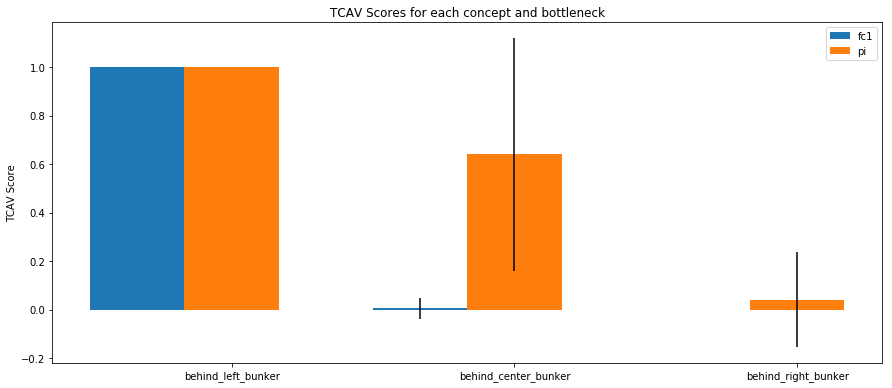

In [8]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

In [9]:
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   "RIGHTFIRE",
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:TCAV will 5200 params
This may take a while... Go get coffee!
INFO:tensorflow:Running param 0 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:/tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 does not exist, Making one...
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.5454545454545454, 'random500_0': 0.9090909090909091, 'overall': 0.7272727272727273}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.5454545454545454, 'random500_0': 0.9090909090909091, 'overall': 0.7272727272727273}
INFO:tensorflow:Runn

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.48484848484848486, 'random500_9': 1.0, 'overall': 0.7424242424242424}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_9': 1.0, 'overall': 0.7424242424242424}
INFO:tensorflow:Running param 10 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.09090909090909091, 'random500_18': 1.0, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 19 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:

INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 29 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'rando

INFO:tensorflow:Running param 38 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.48484848484848486, 'random500_38': 0.9393939393939394, 'overall': 0.7121212121212122}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_38': 0.9393939393939394, 'overall': 0.7121212121212122}
INFO:tensorflow:Running param 39 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker'

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.48484848484848486, 'random500_47': 0.9696969696969697, 'overall': 0.7272727272727273}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_47': 0.9696969696969697, 'overall': 0.7272727272727273}
INFO:tensorflow:Running param 48 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.1

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.030303030303030304, 'random500_6': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 57 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.5151515151515151, 'random500_7': 1.0, 'overall': 0.7575757575757576}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.5151515

INFO:tensorflow:Running param 66 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 67 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activ

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 76 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/a

INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.7878787878787878, 'random500_34': 0.8787878787878788, 'overall': 0.8333333333333334}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.7878787878787878, 'random500_34': 0.8787878787878788, 'overall': 0.8333333333333334}
INFO:tensorflow:Running param 85 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_35'] - fc1 alpha 0.1
IN

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_43': 0.09090909090909091, 'overall': 0.5384615384615384}
INFO:tensorflow:Running param 94 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.8484848484848485, 'random500_44': 0.9696969696969697, 'overall': 0.9090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center

INFO:tensorflow:Running param 103 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.9696969696969697, 'random500_3': 0.9393939393939394, 'overall': 0.9545454545454546}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.9696969696969697, 'random500_3': 0.9393939393939394, 'overall': 0.9545454545454546}
INFO:tensorflow:Running param 104 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.9696969696969697, 'random500_12': 0.8181818181818182, 'overall': 0.8939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.9696969696969697, 'random500_12': 0.8181818181818182, 'overall': 0.8939393939393939}
INFO:tensorflow:Running param 113 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shap

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.9696969696969697, 'random500_21': 0.8787878787878788, 'overall': 0.9242424242424242}
INFO:tensorflow:Running param 122 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.8181818181818182, 'random500_22': 0.9393939393939394, 'overall': 0.8787878787878788}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'beh

INFO:tensorflow:Running param 131 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.7575757575757576, 'random500_31': 0.9696969696969697, 'overall': 0.8636363636363636}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.7575757575757576, 'random500_31': 0.9696969696969697, 'overall': 0.8636363636363636}
INFO:tensorflow:Running param 132 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_b

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.696969696969697, 'random500_40': 0.9696969696969697, 'overall': 0.8333333333333334}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.696969696969697, 'random500_40': 0.9696969696969697, 'overall': 0.8333333333333334}
INFO:tensorflow:Running param 141 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 sha

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.42424242424242425, 'random500_49': 1.0, 'overall': 0.7121212121212122}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.42424242424242425, 'random500_49': 1.0, 'overall': 0.7121212121212122}
INFO:tensorflow:Running param 150 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 160 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 161 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_12']
INFO:tensorflow:Loaded /

INFO:tensorflow:Running param 170 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.8484848484848485, 'random500_21': 0.21212121212121213, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.8484848484848485, 'random500_21': 0.21212121212121213, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 171 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_22']
INFO:tensorflow:Loaded

INFO:tensorflow:Running param 180 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 181 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_0', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 191 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 201 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.6060606060606061, 'random500_12': 0.45454545454545453, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 211 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.21212121212121213, 'random500_13': 0.6363636363636364, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.21212121212121213, 'rand

INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 221 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 222 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_24']
INFO:tensorflow:Loaded /

INFO:tensorflow:Running param 231 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.9393939393939394, 'random500_33': 0.12121212121212122, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.9393939393939394, 'random500_33': 0.12121212121212122, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 232 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_34']
INFO:tensorflow:Loaded

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_1', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 242 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_f

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 252 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2

INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 263 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 273 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'rando

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 284 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 294 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_2', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 304 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 305 of 5200
INFO:tensorflow:running RIGHTFIRE ['rando

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 315 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Training CAV ['random500_3', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 325 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:s

INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 335 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 336 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_40']
INFO:tensorflow:Loaded /

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_3', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.030303030303030304, 'random500_49': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.030303030303030304, 'random500_49': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 346 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 356 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'rando

INFO:tensorflow:Running param 366 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 367 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.06060606060606061, 'random500_31': 0.9090909090909091, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.06060606060606061, 'random500_31': 0.9090909090909091, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 377 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Trainin

INFO:tensorflow:Training CAV ['random500_4', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 387 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_4', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:s

INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 398 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_tes

INFO:tensorflow:Training CAV ['random500_5', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 408 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.06060606060606061, 'random500_14': 1.0, 'overall': 0.5303

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 418 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.696969696969697, 'random500_24': 0.15151515151515152, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving an

INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 428 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 429 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_35']
INFO:tensorflow:Loaded /

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_5', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 439 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Training CAV ['random500_6', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 449 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_pat

INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 459 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 460 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_17']
INFO:tensorflow:Loaded /

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 470 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 480 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'rando

INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_6', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 491 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:Training CAV ['random500_7', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 501 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_pat

INFO:tensorflow:Running param 511 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.5454545454545454, 'random500_19': 0.42424242424242425, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.5454545454545454, 'random500_19': 0.42424242424242425, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 512 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_20']
INFO:tensorflow:Load

INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 522 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 532 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_7', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.15151515151515152, 'random500_49': 0.7272727272727273, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.15151515151515152, 'random500_49': 0.7272727272727273, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 542 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CA

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 552 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.21212121212121213, 'random500_11': 0.7272727272727273, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving an

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.42424242424242425, 'random500_20': 0.6060606060606061, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 562 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 573 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 583 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_8', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_42': 1.0, 'over

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 594 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorfl

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 604 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_14': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:te

INFO:tensorflow:Training CAV ['random500_9', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.5757575757575758, 'random500_23': 0.5151515151515151, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.5757575757575758, 'random500_23': 0.5151515151515151, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 614 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow

INFO:tensorflow:Running param 624 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 625 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:te

INFO:tensorflow:Running param 634 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_9', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.9696969696969697, 'random500_44': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.9696969696969697, 'random500_44': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 635 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 645 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tenso

INFO:tensorflow:Training CAV ['random500_10', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 655 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.09090909090909091, 'random500_16': 0.9696969696969

INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 665 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.24242424242424243, 'random500_26': 0.7575757575757576, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Running param 675 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 676 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 686 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_10', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alph

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.6060606060606061, 'random500_6': 0.30303030303030304, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.6060606060606061, 'random500_6': 0.30303030303030304, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 696 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_7': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 706 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_18': 1.0

INFO:tensorflow:Running param 716 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 717 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 727 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO

INFO:tensorflow:Training CAV ['random500_11', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 737 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_11', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tenso

INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 747 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_9': 1.0, 'over

INFO:tensorflow:Running param 757 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 758 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 768 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
I

INFO:tensorflow:Training CAV ['random500_12', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 778 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_12', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tenso

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 788 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.9696969696969697, 'random500_1': 0.12121212121212122, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.9696969696969697, 'random500_1': 0.12121212121212122, 'overall': 0.545

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.06060606060606061, 'random500_11': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.06060606060606061, 'random500_11': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:Running param 799 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_c

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 809 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alph

INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 819 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_33': 1.0

INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_13', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 830 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.030303030303030304, 'random500_3': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.030303030303030304, 'random500_3': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:Running param 840 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.9393939393939394, 'random500_13': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.9393939393939394, 'random500_13': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:Running param 850 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_c

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.21212121212121213, 'random500_24': 0.8484848484848485, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.21212121212121213, 'random500_24': 0.8484848484848485, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 860 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:L

INFO:tensorflow:Running param 869 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 870 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_14', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.030303030303030304, 'random500_44': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.030303030303030304, 'random500_44': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 880 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 890 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.9393939393939394, 'random500_14': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 900 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 901 of 5200

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.8787878787878788, 'random500_26': 0.0, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.8787878787878788, 'random500_26': 0.0, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 911 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_cla

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 921 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
I

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 931 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_15', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alph

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.36363636363636365, 'random500_6': 0.6363636363636364, 'overall': 0.5}
INFO:tensorflow:Running param 941 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 942 of 5200
INFO

INFO:tensorflow:Running param 951 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.030303030303030304, 'random500_18': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.030303030303030304, 'random500_18': 0.9696969696969697, 'overall': 0.5}
INFO:tensorflow:Running param 952 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tca

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 962 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 972 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.12121212121212122, 'random500_39': 0.8181818181818182, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.12121212121212122, 'random500_39': 0.8181818181818182, 'overall':

INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 982 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_16', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 983 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_0']
INFO:tensorflow:Lo

INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_9': 0.7878787878787878, 'overall': 0.3939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_9': 0.7878787878787878, 'overall': 0.3939393939393939}
INFO:tensorflow:Running param 993 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shap

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1003 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Training CAV ['random500_17', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.06060606060606061, 'random500_30': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.06060606060606061, 'random500_30': 0.9696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1013 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:t

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1023 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_17', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1024 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1034 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tens

INFO:tensorflow:Training CAV ['random500_18', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1044 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.9393939393939394, 'random500_12': 0.0303030303030

INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1054 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_23'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.09090909090909091, 'random500_23': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.09090909090909091, 'random500_23': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1

INFO:tensorflow:Running param 1064 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1065 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 1075 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_18', 'random500_44'] - fc1 alpha 0.1
I

INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1085 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_4': 1.0, 'ove

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1096 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1106 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_35': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1116 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1117 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_19', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1127 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)


INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1137 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_c

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.2727272727272727, 'random500_16': 0.8181818181818182, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.2727272727272727, 'random500_16': 0.8181818181818182, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 1147 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Lo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.8181818181818182, 'random500_27': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.8181818181818182, 'random500_27': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1157 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1167 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1177 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_20', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1187 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1

INFO:tensorflow:acc per class {'random500_21': 0.09090909090909091, 'random500_17': 0.9090909090909091, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.09090909090909091, 'random500_17': 0.9090909090909091, 'overall': 0.5}
INFO:tensorflow:Running param 1197 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1208 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1218 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_21', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1228 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.030303030303030304, 'random500_0': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO

INFO:tensorflow:Running param 1238 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1239 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1249 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)


INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1259 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_41': 0.09090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_41': 0.09090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 1269 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_22', 'ra

INFO:tensorflow:Training CAV ['random500_23', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1279 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:

INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_11': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1289 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1290 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_13']
INFO:tensorflow

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1299 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1300 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1310 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.875, 'random500_43': 0.21212121212121213, 'overall': 0.5384615384615384}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.875, 'random500_43': 0.21212121212121213, 'overall': 0.5384615384615384}
INFO:tensorflow:Running param 1320 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_23', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.3333333333333333, 'random500_44': 0.8484848484848485, 'overal

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1330 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1331 of 5200
INFO:tensorflow:running RIGHTFIRE

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.7878787878787878, 'random500_14': 0.15151515151515152, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.7878787878787878, 'random500_14': 0.15151515151515152, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 1341 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Training CAV ['random500_24', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.8181818181818182, 'random500_25': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.8181818181818182, 'random500_25': 0.24242424242424243, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1351 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:t

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_35': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1361 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1362 of 5

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.45454545454545453, 'random500_45': 0.48484848484848486, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.45454545454545453, 'random500_45': 0.48484848484848486, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 1371 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_24', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_46': 1.0, 'overall'

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1381 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1382 of 5200
INFO:tensorflow:running RIGHTFIRE

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.9393939393939394, 'random500_16': 0.030303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.9393939393939394, 'random500_16': 0.030303030303030304, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1392 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorf

INFO:tensorflow:Running param 1401 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1402 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1412 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:acc per class {'random500_25': 0.3333333333333333, 'random500_47': 0.696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.3333333333333333, 'random500_47': 0.696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1422 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_25', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1432 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1433 of 5200
INFO:tensorflow:running RIGHTFIRE

INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1443 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1453 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_26', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.6060606060606061, 'random500_39': 0.36363636363636365, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.6060606060606061, 'random500_39': 0.36363636363636365, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1463 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:T

INFO:tensorflow:Training CAV ['random500_26', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.21212121212121213, 'random500_49': 0.8484848484848485, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.21212121212121213, 'random500_49': 0.8484848484848485, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1473 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tens

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1483 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.06060606060606061, 'random500_10': 0.8787878787878788, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.06060606060606061, 'random500_10': 0.8787878787878788, 'overall':

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1494 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)


INFO:tensorflow:Training CAV ['random500_27', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.15151515151515152, 'random500_31': 0.9393939393939394, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.15151515151515152, 'random500_31': 0.9393939393939394, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 1504 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:t

INFO:tensorflow:Training CAV ['random500_27', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1514 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_27', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.30303030303030304, 'random500_42': 0.666666666666

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.9393939393939394, 'random500_1': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.9393939393939394, 'random500_1': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 1524 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None

INFO:tensorflow:Training CAV ['random500_28', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.7272727272727273, 'random500_11': 0.30303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.7272727272727273, 'random500_11': 0.30303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1534 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:t

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1544 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1545 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Running param 1554 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1555 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 1565 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_28', 'random500_44'] - fc1 alpha 0.1
INF

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.3333333333333333, 'random500_3': 0.6363636363636364, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.3333333333333333, 'random500_3': 0.6363636363636364, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 1575 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_4': 1.0, 'overall': 0.5}
I

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1585 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_14': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_14': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:ten

INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1595 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.696969696969697, 'random500_24': 0.15151515151515152, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accura

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.030303030303030304, 'random500_34': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1605 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.3939393939393939, 'random500_35': 0.5757575757575758, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.3939393939393939, 'random500_35'

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.8484848484848485, 'random500_44': 0.15151515151515152, 'overall': 0.5}
INFO:tensorflow:Running param 1615 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_29', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.5757575757575758, 'random500_45': 0.3939393939393939, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.5757575757575758, 'random500_45':

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1625 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1626 of 5200
INFO:tensorflow:running RIGHTFIRE

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1636 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Training CAV ['random500_30', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1646 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.18181818181818182, 'random500_26': 0.909090909090

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1656 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1657 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Running param 1666 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_30', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1667 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1677 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_31', 'random500_17'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1687 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.9090909090909091, 'random500_27': 0.12121212121212122, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1697 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.6363636363636364, 'random500_28': 0.2727272727272727, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.6363636363636364, 

INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1707 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.24242424242424243, 'random500_39': 0.696969696969697, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.24242424242424243, 'random500_39': 0.696969696969697, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 1708 

INFO:tensorflow:Running param 1717 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_31', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1718 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1728 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.9696969696969697, 'random500_19': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:Running param 1738 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1739 of 

INFO:tensorflow:Running param 1748 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1749 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_32', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1759 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1769 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1779 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: 

INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1790 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_32': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1800 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Training CAV ['random500_33', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.36363636363636365, 'random500_43': 0.71875, 'overall': 0.5384615384615384}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.36363636363636365, 'random500_43': 0.71875, 'overall': 0.5384615384615384}
INFO:tensorflow:Running param 1810 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_33', 'random500_44'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per clas

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1820 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.18181818181818182, 'random500_4': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.18181818181818182, 'random500_4': 0.7878787878787878, 'overall': 0.4

INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1830 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.21212121212121213, 'random500_14': 0.9090909090909091, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.21212121212121213, 'random500_14': 0.9090909090909091, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 183

INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.030303030303030304, 'random500_24': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.030303030303030304, 'random500_24': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1841 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3

INFO:tensorflow:Training CAV ['random500_34', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1851 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1861 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_34', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.030303030303030304, 'random500_46': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random

INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_5': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 1871 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1872 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'rand

INFO:tensorflow:Running param 1881 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1882 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1892 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Training CAV ['random500_35', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1902 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1912 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_35', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1913 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Running param 1922 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1923 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1933 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1943 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1953 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_36', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Training CAV ['random500_36', 'random500_49'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_49': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_49': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 1963 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random5

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1973 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1974 of 5200
INFO:tensorflow:running RIGH

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 1983 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.36363636363636365, 'random500_20': 0.5757575757575758, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.36363636363636365, 'random500_20': 0.5757575757575758, 'overall'

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 1993 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.9696969696969697, 'random500_30': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.9696969696969697, 'random500_30': 0.030303030303030304, 'overall': 0.5}
INFO:t

INFO:tensorflow:Running param 2003 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_37', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.42424242424242425, 'random500_41': 0.42424242424242425, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.42424242424242425, 'random500_41': 0.42424242424242425, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 2004 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_42']
INFO:tenso

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_1'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.24242424242424243, 'random500_1': 0.6666666666666666, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.24242424242424243, 'random500_1': 0.6666666666666666, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 2014 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Load

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2024 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Training CAV ['random500_38', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2034 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2044 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: 

INFO:tensorflow:Running param 2054 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_38', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2055 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_ran

INFO:tensorflow:Training CAV ['random500_39', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.9696969696969697, 'random500_3': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.9696969696969697, 'random500_3': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:Running param 2065 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random50

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2075 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2076 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2086 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2096 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2106 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_39', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2107 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.3333333333333333, 'random500_6': 0.696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.3333333333333333, 'random500_6': 0.696969696969697, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2117 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /t

INFO:tensorflow:Running param 2126 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2127 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512

INFO:tensorflow:Training CAV ['random500_40', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2137 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_27'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2147 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_37'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2148 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:Running param 2157 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_40', 'random500_48'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2158 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512

INFO:tensorflow:Training CAV ['random500_41', 'random500_8'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.8484848484848485, 'random500_8': 0.18181818181818182, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.8484848484848485, 'random500_8': 0.18181818181818182, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2168 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_9'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorf

INFO:tensorflow:acc per class {'random500_41': 0.7272727272727273, 'random500_18': 0.09090909090909091, 'overall': 0.4090909090909091}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.7272727272727273, 'random500_18': 0.09090909090909091, 'overall': 0.4090909090909091}
INFO:tensorflow:Running param 2178 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_19'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.030303030303030304, 'random500_28': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2188 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_29'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2189 of 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_41', 'random500_39'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2199 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.18181818181818182, 'random500_0': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.18181818181818182, 'random500_0': 0.7878787878787878, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2209 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loa

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2219 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_11'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Training CAV ['random500_42', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2229 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_21'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2239 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_31'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.6060606060606061, 'random500_31': 0.24242424242424243, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.6060606060606061, 'random500_31': 0.24242424242424243, 'overall': 0.42424242424242425}
INFO:tensorflow:Running param 2

INFO:tensorflow:Running param 2249 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_42', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_41': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_41': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2250 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 1.0, 'random500_2': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_2': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 2260 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_12': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_12': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2270 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHT

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.6363636363636364, 'random500_22': 0.1875, 'overall': 0.4153846153846154}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.6363636363636364, 'random500_22': 0.1875, 'overall': 0.4153846153846154}
INFO:tensorflow:Running param 2280 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_32'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.7272727272727273, 'random500_32': 0.3125, 'overall': 0.5230769230769231}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.7272727272727273, 'random500_32': 0.3125, 'overall': 0.5230769230769231}
INFO:tensorflow:Running param 2290 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_42'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 1.0, 'random500_42': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_42': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 2300 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_43', 'random500_44'] - fc1 alpha 0.1
IN

INFO:tensorflow:Training CAV ['random500_44', 'random500_3'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.9393939393939394, 'random500_3': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.9393939393939394, 'random500_3': 0.0, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 2310 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44

INFO:tensorflow:Training CAV ['random500_44', 'random500_13'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2320 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2330 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_24'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: 

INFO:tensorflow:Running param 2340 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_34'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2341 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2351 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_44', 'random500_46'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:Training CAV ['random500_45', 'random500_5'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2361 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_6'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2371 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_16'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.24242424242424243, 'random500_25': 0.7575757575757576, 'overall': 0.5}
INFO:tensorflow:Running param 2381 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_26'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2382 of 5

INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_36'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_36': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_36': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 2392 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_45', 'random500_47'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2402 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_7'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.696969696969697, 'random500_7': 0.2727272727272727, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.696969696969697, 'random500_7': 0.2727272727272727, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2412 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training C

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.9090909090909091, 'random500_17': 0.15151515151515152, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2422 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_18'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.0, 'random500_18': 0.9090909090909091, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.0, 'random500_18': 0.909090909090

INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_28'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2433 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_46', 'random500_38'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.8787878787878788, 'random500_38': 0.06060606060606061, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.8787878787878788, 'random500_38': 0.06060606060606061, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 2443 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.030303030303030304, 'random500_49': 0.9393939393939394, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2453 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_0'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running par

INFO:tensorflow:Running param 2463 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_10'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2464 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_20'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.45454545454545453, 'random500_20': 0.5151515151515151, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.45454545454545453, 'random500_20': 0.5151515151515151, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2474 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_30'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.5151515151515151, 'random500_30': 0.42424242424242425, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.5151515151515151, 'random500_30': 0.42424242424242425, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 2484 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_fc1 shape (100, 512)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_40'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2494 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_47', 'random500_41'] - fc1 alpha 0.1
INFO:tensorflow:training with alp

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2504 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_2'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'rand

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_12'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2515 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_fc1 shape (100, 512)


INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_22'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2525 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INF

INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2535 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_33'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_33': 1.

INFO:tensorflow:Running param 2545 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_fc1 shape (98, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_48', 'random500_43'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_43': 0.18181818181818182, 'overall': 0.5846153846153846}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_43': 0.18181818181818182, 'overall': 0.5846153846153846}
INFO:tensorflow:Running param 2546 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_4'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2556 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_fc1 shape (100, 512)
INFO:t

INFO:tensorflow:Training CAV ['random500_49', 'random500_14'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2566 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_15'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2576 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_25'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_25': 1.

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2586 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_35'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2587 of 5200
INFO:tensorflow:running RIG

INFO:tensorflow:acc per class {'random500_49': 0.7878787878787878, 'random500_44': 0.3333333333333333, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.7878787878787878, 'random500_44': 0.3333333333333333, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 2596 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_fc1 shape (100, 512)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_fc1 shape (100, 512)
INFO:tensorflow:Training CAV ['random500_49', 'random500_45'] - fc1 alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. No

INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.5454545454545454, 'random500_5': 0.7878787878787878, 'overall': 0.6666666666666666}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.5454545454545454, 'random500_5': 0.7878787878787878, 'overall': 0.6666666666666666}
INFO:tensorflow:Running param 2606 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.12121212121212122, 'random500_14': 1.0, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 2615 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.5454545454545454, 'random500_15': 0.696969696969697, 'overall': 0.6212121212121212}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.545454545

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 1.0, 'random500_24': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 1.0, 'random500_24': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2625 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.48484848484848486, 'random500_33': 0.7575757575757576, 'overall': 0.6212121212121212}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.48484848484848486, 'random500_33': 0.7575757575757576, 'overall': 0.6212121212121212}
INFO:tensorflow:Running param 2634 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.181818181

INFO:tensorflow:Running param 2643 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_left_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_left_bunker', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_left_bunker': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_left_bunker': 0.0, 'random500_43': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 2644 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_left_bunker', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_2': 0.09090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_2': 0.09090909090909091, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 2653 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /t

INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_11': 0.21212121212121213, 'overall': 0.6060606060606061}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_11': 0.21212121212121213, 'overall': 0.6060606060606061}
INFO:tensorflow:Running param 2662 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_12': 0.18181818181818182, 'overall': 0.59090909090909

INFO:tensorflow:Running param 2671 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 1.0, 'random500_21': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 1.0, 'random500_21': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2672 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_22']
INFO:t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.06060606060606061, 'random500_30': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.06060606060606061, 'random500_30': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 2681 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Traini

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.7575757575757576, 'random500_39': 0.7272727272727273, 'overall': 0.7424242424242424}
INFO:tensorflow:Running param 2690 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_center_bunker', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.5151515151515151, 'random500_40': 0.9696969696969697, 'overall': 0.7424242424242424}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_center_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_center_bunker', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_center_bunker': 0.6666666666666666, 'random500_49': 0.9090909090909091, 'overall': 0.7878787878787878}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_center_bunker': 0.6666666666666666, 'random500_49': 0.9090909090909091, 'overall': 0.7878787878787878}
INFO:tensorflow:Running param 2700 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi s

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.6666666666666666, 'random500_8': 0.7575757575757576, 'overall': 0.7121212121212122}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.6666666666666666, 'random500_8': 0.7575757575757576, 'overall': 0.7121212121212122}
INFO:tensorflow:Running param 2709 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.1212121212

INFO:tensorflow:Running param 2718 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.45454545454545453, 'random500_18': 0.8787878787878788, 'overall': 0.6666666666666666}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.45454545454545453, 'random500_18': 0.8787878787878788, 'overall': 0.6666666666666666}
INFO:tensorflow:Running param 2719 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker'

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.21212121212121213, 'random500_27': 0.9090909090909091, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.21212121212121213, 'random500_27': 0.9090909090909091, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 2728 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.45454545454545453, 'random500_36': 0.9696969696969697, 'overall': 0.7121212121212122}
INFO:tensorflow:Running param 2737 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.9090909090909091, 'random500_37': 0.7575757575757576, 'overall': 0.8333333333333334}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_righ

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['behind_right_bunker', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'behind_right_bunker': 0.696969696969697, 'random500_46': 0.8787878787878788, 'overall': 0.7878787878787878}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'behind_right_bunker': 0.696969696969697, 'random500_46': 0.8787878787878788, 'overall': 0.7878787878787878}
INFO:tensorflow:Running param 2747 of 5200
INFO:tensorflow:running RIGHTFIRE ['behind_right_bunker', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_behind_right_bunker_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2757 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV [

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.9696969696969697, 'random500_17': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.9696969696969697, 'random500_17': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2767 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not sa

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2778 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded

INFO:tensorflow:acc per class {'random500_0': 0.6363636363636364, 'random500_38': 0.2727272727272727, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.6363636363636364, 'random500_38': 0.2727272727272727, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 2788 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.2727272727272727, 'random500_39': 0.7272727272727273, 'overall': 0.5}
INFO:tensorflow:save_

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2798 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_0', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_0', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_0': 0.696969696969697, 'random500_49': 0.36363636363636365, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_0': 0.696969696969697, 'random500_49': 0.36363636363636365, 'overall': 0.53030303030303

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2809 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorfl

INFO:tensorflow:Running param 2819 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.8181818181818182, 'random500_21': 0.30303030303030304, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.8181818181818182, 'random500_21': 0.30303030303030304, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 2820 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_22']
INFO:tensorflow:Loaded /tmp/ry

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2830 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorfl

INFO:tensorflow:Running param 2840 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_1', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_42': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_42': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 2841 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_1', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/act

INFO:tensorflow:Training CAV ['random500_2', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2851 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None.

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_14': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2862 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2872 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.09090909090909091, 'random500_25': 0.9393939393939394, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_35': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_35': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2883 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:Training CAV ['random500_2', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2893 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_2', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_2', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2904 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_17': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2914 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2925 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded

INFO:tensorflow:Training CAV ['random500_3', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_38': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2935 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_3', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_39': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_3', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2946 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training C

INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2956 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2957 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:Training CAV ['random500_4', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 2967 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2977 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2978 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_4', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 2988 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_4', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/acti

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.696969696969697, 'random500_2': 0.42424242424242425, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.696969696969697, 'random500_2': 0.42424242424242425, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 2998 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.9696969696969697, 'random500_3': 0.0, 'overall': 0.4848484

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3008 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 

INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_23': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3018 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.696969696969697, 'random500_24': 0.45454545454545453, 'overall': 0.5757575757575758}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.696969696969697, 'random500_24': 0.45454545454545453, 'overall': 0.5757575757575758}
INFO:tensorflow:Runn

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.45454545454545453, 'random500_34': 0.696969696969697, 'overall': 0.5757575757575758}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.45454545454545453, 'random500_34': 0.696969696969697, 'overall': 0.5757575757575758}
INFO:tensorflow:Running param 3029 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansulli

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_5': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_5': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3039 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_5', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_5', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorfl

INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3049 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.7272727272727273, 'random500_5': 0.3333333333333333, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.7272727272727273, 'random500_5': 0.3333333333333333, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3050 of 5200
INFO:tensorflo

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.9090909090909091, 'random500_16': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.9090909090909091, 'random500_16': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3060 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['rand

INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3070 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3071 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3081 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:Training CAV ['random500_6', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.7272727272727273, 'random500_47': 0.2727272727272727, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_6': 0.7272727272727273, 'random500_47': 0.2727272727272727, 'overall': 0.5}
INFO:tensorflow:Running param 3091 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_6', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_6', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_6': 0.0, 'ran

INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.24242424242424243, 'random500_9': 0.6666666666666666, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.24242424242424243, 'random500_9': 0.6666666666666666, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 3102 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_ra

INFO:tensorflow:Training CAV ['random500_7', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.7878787878787878, 'random500_19': 0.24242424242424243, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.7878787878787878, 'random500_19': 0.24242424242424243, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3112 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3122 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3123 of 5200
INFO:tensorflow:running RIGHTFIRE ['random5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_7', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_7': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_7': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3133 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_7', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_0': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3143 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, '

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3154 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3164 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.09090909090909091, 'random500_23': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.09090909090909091, 'random500_23': 0.8787878787878788, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3165 of 5200
INFO

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3175 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training

INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_43': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 3185 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_8', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_8', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_44': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accura

INFO:tensorflow:Running param 3195 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3196 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3206 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.9696969696969697, 'random500_25': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3216 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.45454545454545453, 'random500_26': 0.3939393939393939, 'overall': 0.42424242424242425}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.45454545454545453, 'random500_26': 0.39393939393

INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3227 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/acti

INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3237 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_9', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_9', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_47': 1.0, 'overall': 0.5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3248 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3258 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3259 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Running param 3268 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3269 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Training CAV ['random500_10', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.030303030303030304, 'random500_39': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.030303030303030304, 'random500_39': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3279 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_10', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_10', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10'

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_10': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_10': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3289 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_0': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflo

INFO:tensorflow:Running param 3299 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3300 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 1.0, 'random500_21': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 1.0, 'random500_21': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3310 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:Running param 3319 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.6060606060606061, 'random500_31': 0.6363636363636364, 'overall': 0.6212121212121212}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.6060606060606061, 'random500_31': 0.6363636363636364, 'overall': 0.6212121212121212}
INFO:tensorflow:Running param 3320 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_32']
INFO:tensorflow:Loaded /tm

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_11', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_11': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_11': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3330 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_11', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3340 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.12121212121212122, 'random500_11': 0.9090909090909091, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3350 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.8484848484848485, 'random500_13': 0.06060606060606061, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.8484848484848485, 'random50

INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_22': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3360 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.06060606060606061, 'random500_23': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.06060606060606061, 'random500_23': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3361 of 5200
INFO:tensorflow:running RIGHTF

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_33': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3371 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 0.0, 'random500_43': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 3381 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_12', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_12', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_12': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_12': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3382 of 5200
INFO:tensorflow:runni

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3392 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorfl

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_15': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3402 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_16': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3403 of 5200
INFO:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 0.5757575757575758, 'random500_26': 0.3333333333333333, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.5757575757575758, 'random500_26': 0.3333333333333333, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 3413 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3423 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:acc per class {'random500_13': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 0.0, 'random500_46': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3433 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_13', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_13', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_13': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_13': 1.0, 'random500_47': 0.0, 'overal

INFO:tensorflow:Running param 3443 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3444 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3454 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Running param 3464 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3465 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_14': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 1.0, 'random500_39': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3475 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_14', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_14', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:acc per class {'random500_14': 0.3939393939393939, 'random500_49': 0.48484848484848486, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_14': 0.3939393939393939, 'random500_49': 0.48484848484848486, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 3485 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving any

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.9090909090909091, 'random500_10': 0.09090909090909091, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.9090909090909091, 'random500_10': 0.09090909090909091, 'overall': 0.5}
INFO:tensorflow:Running param 3496 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/ac

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.9090909090909091, 'random500_21': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.9090909090909091, 'random500_21': 0.030303030303030304, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3506 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV [

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.15151515151515152, 'random500_31': 0.7878787878787878, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.15151515151515152, 'random500_31': 0.7878787878787878, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 3516 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:

INFO:tensorflow:Running param 3526 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_15', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_15': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_15': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3527 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_15', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3537 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorfl

INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3547 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3548 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_14']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3558 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3568 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 0.0, 'random500_35': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 0.0, 'random500_35': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3569 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_36']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_16', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_16': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_16': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3579 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_16', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_5': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3589 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3590 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3600 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3610 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 1.0, 'random500_28': 0.0, 'overal

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.06060606060606061, 'random500_38': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.06060606060606061, 'random500_38': 1.0, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3621 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/ac

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_17': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3631 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_17', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_17', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_17': 0.21212121212121213, 'random500_49': 0.8787878787878788, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anyth

INFO:tensorflow:Running param 3641 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3642 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3652 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.7575757575757576, 'random500_30': 0.2727272727272727, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 3662 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 1.0, 'random500_31': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3663 

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_18', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_18': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_18': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3673 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_18', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_1': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3683 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_2': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3684 of 5200
INFO:tensorf

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 1.0, 'random500_12': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3694 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3704 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3715 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:Training CAV ['random500_19', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_19': 0.0, 'random500_44': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3725 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_19', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_19', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_19': 1.0, 'random500_45': 0.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:Running param 3735 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.30303030303030304, 'random500_5': 0.6666666666666666, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 0.30303030303030304, 'random500_5': 0.6666666666666666, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 3736 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_6']
INFO:tensorflow:Loaded /tmp/

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3746 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3756 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.9696969696969697, 'random500_27': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_37': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3767 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_20': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3777 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_20', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_20', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_20': 0.09090909090909091, 'random500_48': 0.9090909090909091, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensor

INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.8181818181818182, 'random500_8': 0.09090909090909091, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.8181818181818182, 'random500_8': 0.09090909090909091, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 3788 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/ac

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_18': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3798 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Running param 3808 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3809 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_21', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_21': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_21': 1.0, 'random500_40': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3819 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_21', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3829 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_1': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3830 of 5200
INFO:tensorflow:running RIGHTFIRE ['random5

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.9393939393939394, 'random500_11': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.9393939393939394, 'random500_11': 0.06060606060606061, 'overall': 0.5}
INFO:tensorflow:Running param 3840 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/ac

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.0, 'random500_21': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3850 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.48484848484848486, 'random500_23': 0.42424242424242425, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving any

INFO:tensorflow:Running param 3860 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3861 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_22', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_22': 0.65625, 'random500_43': 0.30303030303030304, 'overall': 0.47692307692307695}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_22': 0.65625, 'random500_43': 0.30303030303030304, 'overall': 0.47692307692307695}
INFO:tensorflow:Running param 3871 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_22', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_clas

INFO:tensorflow:Training CAV ['random500_23', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3881 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.9393939393939394, 'random500_4': 0.0, 'overall': 0.469696969696969

INFO:tensorflow:CAV accuracies: {'random500_23': 0.24242424242424243, 'random500_13': 0.8484848484848485, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 3891 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3892 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_

INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3902 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3912 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_36': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_23', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_23': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_23': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3923 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_23', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:Training CAV ['random500_24', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3933 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.8787878787878788, 'random500_17': 0.12121212121212122, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.8787878787878788, 'random500_17': 0.12121212121212122, 'overall': 0.5}
INFO:tensorflow:Running param 3944 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3954 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:acc per class {'random500_24': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 3964 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.5757575757575758, 'random500_39': 0.45454545454545453, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'ra

INFO:tensorflow:running RIGHTFIRE ['random500_24', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_24', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_24': 0.36363636363636365, 'random500_49': 0.5454545454545454, 'overall': 0.45454545454545453}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_24': 0.36363636363636365, 'random500_49': 0.5454545454545454, 'overall': 0.45454545454545453}
INFO:tensorflow:Running param 3975 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activatio

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 3985 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Trainin

INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_19': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_19': 0.06060606060606061, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 3995 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.3333333333333333, 'random500_20': 0.7575757575757576, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is N

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4005 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4006 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_25': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_25': 1.0, 'random500_41': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4016 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_25', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_25', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Running param 4026 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4027 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4037 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_22': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4047 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4048 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 0.0, 'random500_34': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4058 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_26': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4068 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_26', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_26', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_26': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Running param 4078 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.21212121212121213, 'random500_5': 0.8787878787878788, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.21212121212121213, 'random500_5': 0.8787878787878788, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 4079 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_6']
INFO:tensorflow:Loaded /tmp/ry

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_15': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4089 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4099 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 0.0, 'random500_37': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 0.0, 'random500_37': 0.9696969696969697, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4110 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/ac

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_27': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_27': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4120 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_27', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_27', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4130 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_8': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4131 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4141 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4151 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.30303030303030304, 'random500_30': 0.6363636363636364, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.30303030303030304, 'random500_30': 0.6363636363636364, 'overall': 0.469696

INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_28', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_28': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_28': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4162 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_28', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:Training CAV ['random500_29', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4172 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_1': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_10': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4182 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4183 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_12']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_21': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4193 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:Training CAV ['random500_29', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_32': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4203 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 0.9696969696969697, 'random500_33': 0.0, 'overall': 0.48484848

INFO:tensorflow:CAV accuracies: {'random500_29': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4213 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_29', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_29': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_29': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4214 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_29', 'random500

INFO:tensorflow:Training CAV ['random500_30', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4224 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_4': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path i

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4235 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_24': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4245 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_25': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4246 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 1.0, 'random500_36': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 1.0, 'random500_36': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4256 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.6060606060606061, 'random500_46': 0.15151515151515152, 'overall': 0.3787878787878788}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_30': 0.6060606060606061, 'random500_46': 0.15151515151515152, 'overall': 0.3787878787878788}
INFO:tensorflow:Running param 4266 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_30', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_30', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_30': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:

INFO:tensorflow:Running param 4276 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4277 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Training CAV ['random500_31', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.06060606060606061, 'random500_17': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.06060606060606061, 'random500_17': 0.9393939393939394, 'overall': 0.5}
INFO:tensorflow:Running param 4287 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 

INFO:tensorflow:Running param 4297 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_28': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4298 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_39'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 0.2727272727272727, 'random500_39': 0.8484848484848485, 'overall': 0.5606060606060606}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 0.2727272727272727, 'random500_39': 0.8484848484848485, 'overall': 0.5606060606060606}
INFO:tensorflow:Running param 4308 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_31', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/rya

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_31', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_31': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_31': 1.0, 'random500_49': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4318 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tenso

INFO:tensorflow:CAV accuracies: {'random500_32': 0.9696969696969697, 'random500_9': 0.030303030303030304, 'overall': 0.5}
INFO:tensorflow:Running param 4328 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.9696969696969697, 'random500_10': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.9696969696969697, 'random500_10': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4329 of 5200

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4339 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4349 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_31': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4350 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_32', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_32': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_32': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4360 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_32', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:L

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4370 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.9696969696969697, 'random500_3': 0.09090909090909091, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
IN

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4381 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4391 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.30303030303030304, 'random500_24': 0.7878787878787878, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'ra

INFO:tensorflow:Running param 4401 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4402 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_33', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_33': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_33': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4412 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_33', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:acc per class {'random500_34': 0.12121212121212122, 'random500_5': 0.9393939393939394, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.12121212121212122, 'random500_5': 0.9393939393939394, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 4422 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anyth

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4433 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:acc per class {'random500_34': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4443 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_27': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_27': 1.0, 'overal

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4454 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 1.0, 'random500_48': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4464 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_34', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_34', 'random500_49'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_34': 0.5757575757575758, 'random500_49': 0.45454545454545453, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_34': 0.5757575757575758, 'random500_49': 0.45454545454545453, 'overall': 0.515151

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_9': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4475 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_10']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Load

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 1.0, 'random500_19': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4485 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_20_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_20'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_20': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4496 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:Training CAV ['random500_35', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_35': 0.0, 'random500_41': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4506 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_35', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_35', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_35': 0.0, 'random500_42': 1.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_2': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4517 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/act

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.12121212121212122, 'random500_12': 0.9393939393939394, 'overall': 0.5303030303030303}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.12121212121212122, 'random500_12': 0.9393939393939394, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 4527 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['r

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.9696969696969697, 'random500_22': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4537 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_23_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4538 of 5200
INFO:t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_33'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_33': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4548 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:acc per class {'random500_36': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 1.0, 'random500_44': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4558 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_36', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_36', 'random500_45'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_36': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_36': 0.0, 'random500_45': 1.0, 'overal

INFO:tensorflow:Running param 4568 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_5']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_5_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_5'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4569 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Training CAV ['random500_37', 'random500_15'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4579 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.030303030303030304, 'random500_16': 1.0, 'overall': 0.515151

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4589 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_26']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_26_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_26': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4590 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_36_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_36'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_36': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4600 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:

INFO:tensorflow:Training CAV ['random500_37', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_37': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4610 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_37', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_37', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_37': 0.09090909090909091, 'random500_48': 0.9393939393939394, 'over

INFO:tensorflow:CAV accuracies: {'random500_38': 1.0, 'random500_7': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4620 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_8_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_8'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4621 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryan

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 1.0, 'random500_18': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4631 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4641 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_29']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_29_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Running param 4651 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_38', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_38': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_38': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4652 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_38', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_0': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4662 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_1']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_1_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training 

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4672 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_11'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.0, 'random500_11': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4673 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.18181818181818182, 'random500_21': 0.9696969696969697, 'overall': 0.5757575757575758}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.18181818181818182, 'random500_21': 0.9696969696969697, 'overall': 0.5757575757575758}
INFO:tensorflow:Running param 4683 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.9696969696969697, 'random500_31': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.9696969696969697, 'random500_31': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4693 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_32'] 

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 0.030303030303030304, 'random500_42': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_39': 0.030303030303030304, 'random500_42': 1.0, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4703 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_39', 'random500_43']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_39', 'random500_43'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_39': 1.0, 'random500_43': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:sa

INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.9696969696969697, 'random500_3': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.9696969696969697, 'random500_3': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4714 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_13': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4724 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_14']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_23': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4734 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.9696969696969697, 'random500_24': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.9696969696969697, 'random500_24': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Ru

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 1.0, 'random500_34': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4745 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_40': 0.0, 'random500_45': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4755 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_40', 'random500_46']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_40', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_40': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Running param 4765 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_6': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4766 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4776 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_17']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_17_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.9696969696969697, 'random500_26': 0.0, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 4786 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_27': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4787 of 5200
INFO:t

INFO:tensorflow:Running param 4796 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 1.0, 'random500_37': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 1.0, 'random500_37': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4797 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_

INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_48']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_41', 'random500_48'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_41': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_41': 0.0, 'random500_48': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4807 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_41', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_8': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4817 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42':

INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4828 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 1.0, 'random500_29': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4838 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 1.0, 'random500_30': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random50

INFO:tensorflow:Running param 4848 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_42', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_42': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_42': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4849 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_42', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Training CAV ['random500_43', 'random500_1'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_1': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_1': 1.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 4859 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_2']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_2_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_2'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_2': 1.0, 'overall': 0.5

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.9090909090909091, 'random500_11': 0.1875, 'overall': 0.5538461538461539}
INFO:tensorflow:Running param 4869 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_12']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_12_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_12'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.53125, 'random500_12': 0.6060606060606061, 'overall': 0.5692307692307692}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.53125, 'random500_12': 0.6060606060606061, 'overall': 

INFO:tensorflow:Running param 4879 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_22']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_22_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_22'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 1.0, 'random500_22': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_22': 0.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4880 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_23']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_32_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_32'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 1.0, 'random500_32': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 1.0, 'random500_32': 0.0, 'overall': 0.5076923076923077}
INFO:tensorflow:Running param 4890 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_33']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_33_pi sha

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_42'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_43': 0.0, 'random500_42': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_43': 0.0, 'random500_42': 1.0, 'overall': 0.49230769230769234}
INFO:tensorflow:Running param 4900 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_43', 'random500_44']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_43_pi shape (98, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_43', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.6363636363636364, 'random500_3': 0.24242424242424243, 'overall': 0.4393939393939394}
INFO:tensorflow:Running param 4910 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_4']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_4_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_4'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_4': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4911 of 52

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_14_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_14'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_14': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4921 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_15']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_15_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:Training CAV ['random500_44', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 0.0, 'random500_24': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4931 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_25']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_25_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_25'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_25': 1.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_35']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_35_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_35'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_35': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4942 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_36']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:Training CAV ['random500_44', 'random500_46'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_44': 1.0, 'random500_46': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4952 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_44', 'random500_47']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_44_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_44', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_44': 0.0, 'random500_47': 1.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:Running param 4962 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_7']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_7_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_7'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_7': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4963 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_8']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:L

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_17'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_17': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 4973 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_18']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_18_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_18'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 1.0, 'random500_27': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 4983 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_28']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_28_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_28'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_28': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4984 of 5200
INFO:

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_38_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_45', 'random500_38'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_45': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_38': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 4994 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_45', 'random500_39']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_39_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_45': 0.0, 'random500_49': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5004 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_0']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_0_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_0'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.696969696969697, 'random500_0': 0.3939393939393939, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.696969696969697, 'random500_0': 0.3939393939393939, 'overall': 0.545454545454545

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_10_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_10'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.0, 'random500_10': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5015 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_11']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_11_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_20': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5025 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_21']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_21_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_21'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.42424242424242425, 'random500_21': 0.45454545454545453, 'overall': 0.4393939393939394}
INFO:tensorflow:save_path is None. Not saving anyt

INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_31']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_31_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_31'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 0.9393939393939394, 'random500_31': 0.15151515151515152, 'overall': 0.5454545454545454}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 0.9393939393939394, 'random500_31': 0.15151515151515152, 'overall': 0.5454545454545454}
INFO:tensorflow:Running param 5036 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_32']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activation

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_41_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_46', 'random500_41'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_46': 1.0, 'random500_41': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_46': 1.0, 'random500_41': 0.030303030303030304, 'overall': 0.5151515151515151}
INFO:tensorflow:Running param 5046 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_46', 'random500_42']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_46_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_42_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.30303030303030304, 'random500_2': 0.48484848484848486, 'overall': 0.3939393939393939}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.30303030303030304, 'random500_2': 0.48484848484848486, 'overall': 0.3939393939393939}
INFO:tensorflow:Running param 5056 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_3']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_3_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_3'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_3': 0.0, 'overall': 0.5}
INFO:tens

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.0, 'random500_12': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5066 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_13']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_13_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_13'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 1.0, 'random500_13': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5067 of 5200
INFO:tensorflow:running RIGHTFIRE ['r

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_23'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.0, 'random500_23': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5077 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_24']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_24_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_24'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Running param 5087 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_34']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_34_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_34'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.8484848484848485, 'random500_34': 0.09090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.8484848484848485, 'random500_34': 0.09090909090909091, 'overall': 0.4696969696969697}
INFO:tensorflow:Running param 5088 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_35']
INFO:tensorflow:Loaded /

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_47', 'random500_44'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_47': 0.3333333333333333, 'random500_44': 0.6363636363636364, 'overall': 0.48484848484848486}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_47': 0.3333333333333333, 'random500_44': 0.6363636363636364, 'overall': 0.48484848484848486}
INFO:tensorflow:Running param 5098 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_47', 'random500_45']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_45_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['r

INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_5': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5108 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_6']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_6_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_6'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_6': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48':

INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_15': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5118 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_16']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_16_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_16'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_16': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5119 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_17']
INFO:tensorflow:Loaded /t

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_26'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_26': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5129 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_27']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_27_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_27'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:te

INFO:tensorflow:Running param 5139 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_37']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_37_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_37'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 0.0, 'random500_37': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5140 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_38']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensor

INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_47_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_48', 'random500_47'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_48': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_48': 1.0, 'random500_47': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5150 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_48', 'random500_49']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_48_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Tra

INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.30303030303030304, 'random500_8': 0.7575757575757576, 'overall': 0.5303030303030303}
INFO:tensorflow:Running param 5160 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_9']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_9_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_9'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 1.0, 'random500_9': 0.0, 'overall': 0.5}
INFO:tensorflow:Running param 5161 of 52

INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_19']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_19_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_19'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_19': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5171 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_20']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_te

INFO:tensorflow:Training CAV ['random500_49', 'random500_29'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_29': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5181 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_30']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_30_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_30'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_30': 1.0, 'overall': 0.5}
INFO:tensorflow:save

INFO:tensorflow:Running param 5191 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_40']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_40_pi shape (100, 6)
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_RIGHTFIRE_pi shape (100, 6)
INFO:tensorflow:Training CAV ['random500_49', 'random500_40'] - pi alpha 0.1
INFO:tensorflow:training with alpha=0.1
INFO:tensorflow:acc per class {'random500_49': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:save_path is None. Not saving anything
INFO:tensorflow:CAV accuracies: {'random500_49': 0.0, 'random500_40': 1.0, 'overall': 0.5}
INFO:tensorflow:Running param 5192 of 5200
INFO:tensorflow:running RIGHTFIRE ['random500_49', 'random500_41']
INFO:tensorflow:Loaded /tmp/ryansullivan/tcav_class_test/activations/acts_random500_49_pi shape (100, 6)
INFO:tensor

##### 

Class = RIGHTFIRE
  Concept = behind_left_bunker
    Bottleneck = fc1. TCAV Score = 0.00 (+- 0.00), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 0.00 (+- 0.00), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = behind_center_bunker
    Bottleneck = fc1. TCAV Score = 0.02 (+- 0.00), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 0.95 (+- 0.19), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
  Concept = behind_right_bunker
    Bottleneck = fc1. TCAV Score = 0.02 (+- 0.00), random was 0.50 (+- 0.49). p-val = 0.000 (significant)
    Bottleneck = pi. TCAV Score = 1.00 (+- 0.00), random was 0.50 (+- 0.50). p-val = 0.000 (significant)
{'fc1': {'bn_vals': [0.0, 0.02, 0.02], 'bn_stds': [0.0, 0.0, 0.0], 'significant': [True, True, True]}, 'pi': {'bn_vals': [0.0, 0.9505999999999998, 0.9992], 'bn_stds': [0.0, 0.1942823718199878, 0.003919183588453088], 'significant': [True, True, True]}}


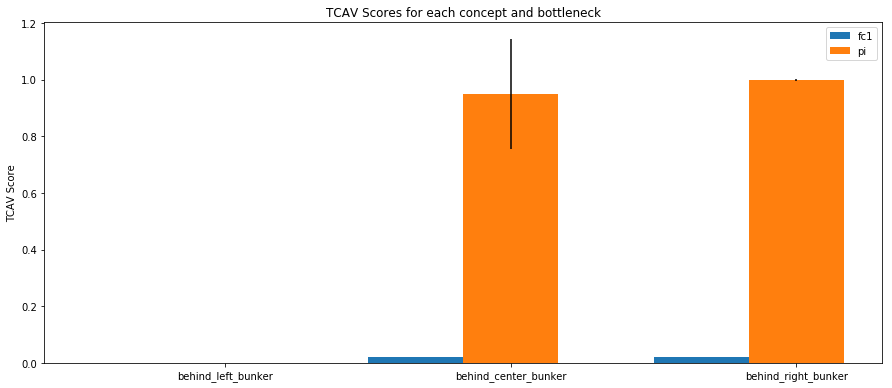

In [10]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

# 

In [11]:
print(GRAPH_PATH)

/home/ryansullivan/Documents/TCAV-RL/tcav/saves/squared_flip_agent_42.pb
